# Consistency: CEBRA for consistent and interpretable embeddings

In this notebook, we show how to 

- use CEBRA-Time and CEBRA-Behavior.
- compute the consistency between CEBRA embeddings.


It is mostly based on what we present in Figure 1.

- Install note: be sure you have cebra, and the demo dependencies, installed to use this notebook: 

In [ ]:
!pip install 'cebra[datasets,demos]'

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra.datasets
from cebra import CEBRA

- Be sure you have downloaded the data and placed `/data` from [FigShare](https://figshare.com/s/60adb075234c2cc51fa3) and into the `demo_notebooks` directory. Let's check if it's there:

In [1]:
ls

Demo_Allen.ipynb                      Demo_learnable_temperature.ipynb
Demo_cohomology.ipynb                 Demo_primate_reaching.ipynb
Demo_consistency.ipynb                Demo_primate_reaching_mse_loss.ipynb
Demo_conv-pivae.ipynb                 Demo_synthetic_exp.ipynb
Demo_decoding.ipynb                   README.rst
Demo_hippocampus.ipynb                data/
Demo_hippocampus_multisession.ipynb   rat_demo_example_output.h5
Demo_hypothesis_testing.ipynb


### Load the data:

In [2]:
hippocampus_pos = {}
hippocampus_pos["achilles"] = cebra.datasets.init('rat-hippocampus-single-achilles')
hippocampus_pos["buddy"] = cebra.datasets.init('rat-hippocampus-single-buddy')
hippocampus_pos["cicero"] = cebra.datasets.init('rat-hippocampus-single-cicero')
hippocampus_pos["gatsby"] = cebra.datasets.init('rat-hippocampus-single-gatsby')

### Visualize the data:

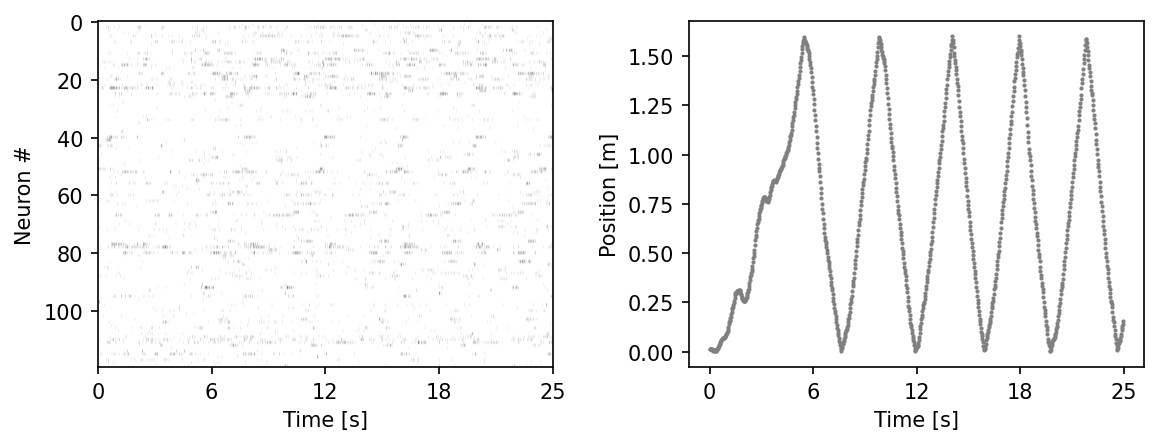

In [3]:
fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(hippocampus_pos["achilles"].neural.numpy()[:1000].T, aspect = 'auto', cmap = 'gray_r')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), hippocampus_pos["achilles"].continuous_index[:1000,0], c = 'gray', s=1)
plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))
plt.show()

**------------------- BEGINNING OF TRAINING SECTION -------------------**

## Training the models

*[You can skip this section if you already have the models saved]*

- For a quick CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000.

In [4]:
max_iterations = 15000 #default is 5000.

### CEBRA-Time: Train a model that uses time without the behavior information. 
- We can use CEBRA -Time mode by setting conditional = 'time'
- We train the model with neural data only.

In [5]:
for mouse in list(hippocampus_pos.keys()):

    cebra_time3_model = CEBRA(model_architecture='offset10-model',
                            batch_size=512,
                            learning_rate=3e-4,
                            temperature=1.12,
                            output_dimension=3,
                            max_iterations=max_iterations,
                            distance='cosine',
                            conditional='time',
                            device='cuda_if_available',
                            verbose=True,
                            time_offsets=10)
    
    cebra_time3_model.fit(hippocampus_pos[mouse].neural)
    cebra_time3_model.save(f"cebra_time3_model_{mouse}.pt")
    

pos:  0.0217 neg:  5.4777 total:  5.4995 temperature:  1.1200: 100%|██████████| 15000/15000 [04:44<00:00, 52.76it/s]
pos:  0.1037 neg:  5.4900 total:  5.5938 temperature:  1.1200: 100%|██████████| 15000/15000 [04:24<00:00, 56.71it/s]
pos:  0.2504 neg:  5.4891 total:  5.7395 temperature:  1.1200: 100%|██████████| 15000/15000 [04:34<00:00, 54.56it/s]
pos:  0.0817 neg:  5.4887 total:  5.5705 temperature:  1.1200: 100%|██████████| 15000/15000 [05:00<00:00, 49.93it/s]


### CEBRA-Behavior: Train a model with 3D output that uses positional information (position + direction).
- Setting conditional = 'time_delta' means we will use CEBRA-Behavior mode and use auxiliary behavior variable for the model training.
- We train the model with neural data and the behavior variable including position and direction. 

In [6]:
for mouse in list(hippocampus_pos.keys()):

    cebra_posdir3_model = CEBRA(model_architecture='offset10-model',
                            batch_size=512,
                            learning_rate=3e-4,
                            temperature=1,
                            output_dimension=3,
                            max_iterations=max_iterations,
                            distance='cosine',
                            conditional='time_delta',
                            device='cuda_if_available',
                            verbose=True,
                            time_offsets=10)
    
    cebra_posdir3_model.fit(hippocampus_pos[mouse].neural, hippocampus_pos[mouse].continuous_index.numpy())
    cebra_posdir3_model.save(f"cebra_posdir3_model_{mouse}.pt")

pos:  0.0837 neg:  5.4119 total:  5.4956 temperature:  1.0000: 100%|██████████| 15000/15000 [04:33<00:00, 54.89it/s]
pos:  0.1597 neg:  5.4356 total:  5.5953 temperature:  1.0000: 100%|██████████| 15000/15000 [04:26<00:00, 56.31it/s]
pos:  0.3737 neg:  5.4740 total:  5.8477 temperature:  1.0000: 100%|██████████| 15000/15000 [04:01<00:00, 62.11it/s]
pos:  0.1054 neg:  5.4429 total:  5.5484 temperature:  1.0000: 100%|██████████| 15000/15000 [05:02<00:00, 49.60it/s]


**------------------- END OF TRAINING SECTION -------------------**

## Load the models and get the embeddings

In [3]:
time3_models, time3_embeddings = {}, {}
posdir3_models, posdir3_embeddings = {}, {}
left, right = {}, {}

for mouse in list(hippocampus_pos.keys()):
    # time constrative models
    time3_models[mouse] = cebra.CEBRA.load(f"cebra_time3_model_{mouse}.pt")
    time3_embeddings[mouse] = time3_models[mouse].transform(hippocampus_pos[mouse].neural)
    
    # behavioral contrastive models
    posdir3_models[mouse] = cebra.CEBRA.load(f"cebra_posdir3_model_{mouse}.pt")
    posdir3_embeddings[mouse] = posdir3_models[mouse].transform(hippocampus_pos[mouse].neural)
    
    # left and right labels for the embedding
    right[mouse] = hippocampus_pos[mouse].continuous_index[:,1] == 1
    left[mouse] = hippocampus_pos[mouse].continuous_index[:,2] == 1

## Display the embeddings

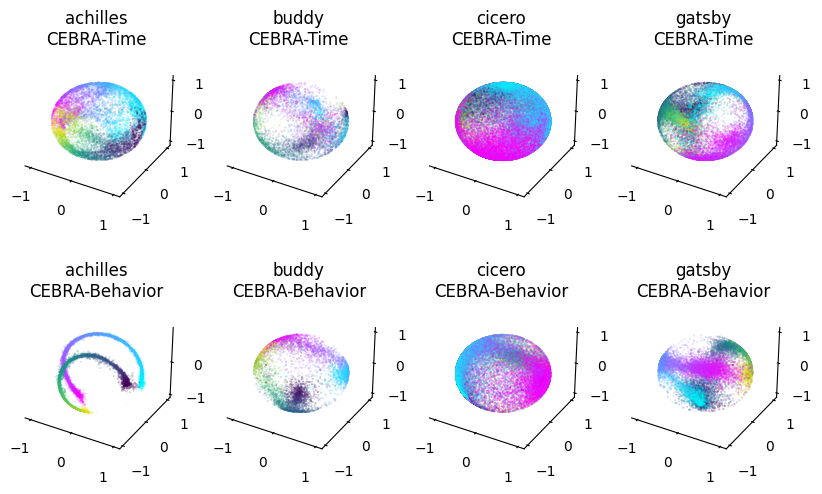

In [4]:
%matplotlib notebook
fig = plt.figure(figsize=(10,6))

ax1 = plt.subplot(241, projection='3d')
ax2 = plt.subplot(242, projection='3d')
ax3 = plt.subplot(243, projection='3d')
ax4 = plt.subplot(244, projection='3d')
axs_up = [ax1, ax2, ax3, ax4]

ax1 = plt.subplot(245, projection='3d')
ax2 = plt.subplot(246, projection='3d')
ax3 = plt.subplot(247, projection='3d')
ax4 = plt.subplot(248, projection='3d')
axs_down = [ax1, ax2, ax3, ax4]

for ax, mouse in  zip(axs_up, list(time3_embeddings.keys())): 
    for dir, cmap in zip([right[mouse], left[mouse]], ["cool", "viridis"]):
        ax=cebra.plot_embedding(ax=ax, embedding=time3_embeddings[mouse][dir,:], embedding_labels=hippocampus_pos[mouse].continuous_index[dir,0], title=f"{mouse}\nCEBRA-Time", cmap=cmap)

for ax, mouse in  zip(axs_down, list(posdir3_embeddings.keys())): 
    for dir, cmap in zip([right[mouse], left[mouse]], ["cool", "viridis"]):
        ax=cebra.plot_embedding(ax=ax, embedding=posdir3_embeddings[mouse][dir,:], embedding_labels=hippocampus_pos[mouse].continuous_index[dir,0], title=f"{mouse}\nCEBRA-Behavior", cmap=cmap)


plt.show()

## Compute the consistency maps

Correlation matrices depict the $R^2$ after fitting a linear model between behavior-aligned embeddings of two animals, one as the target one as the source (mean, n=10 runs). Parameters were picked by optimizing average run consistency across rats.

In [5]:
# labels to align the subjects is the position of the mouse in the arena
labels = [hippocampus_pos[mouse].continuous_index[:, 0]
          for mouse in list(hippocampus_pos.keys())]

# CEBRA-Time consistencies
time_scores, time_pairs, time_subjects = cebra.sklearn.metrics.consistency_score(embeddings=list(time3_embeddings.values()),
                                                                                 labels=labels,
                                                                                 dataset_ids=list(
                                                                                     time3_embeddings.keys()),
                                                                                 between="datasets")

# CEBRA-Behavior consistencies
posdir_scores, posdir_pairs, posdir_subjects = cebra.sklearn.metrics.consistency_score(embeddings=list(posdir3_embeddings.values()),
                                                                                       labels=labels,
                                                                                       dataset_ids=list(
                                                                                           posdir3_embeddings.keys()),
                                                                                       between="datasets")


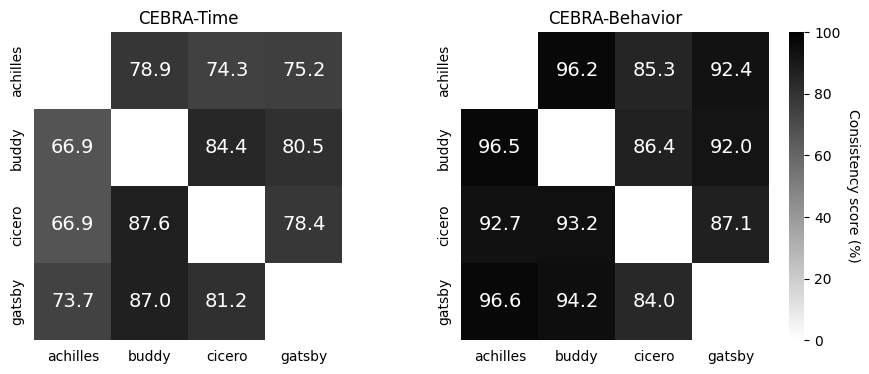

In [6]:
# Display consistency maps
%matplotlib inlinefig = plt.figure(figsize=(11, 4))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1 = cebra.plot_consistency(time_scores, pairs=time_pairs, datasets=time_subjects,
                             ax=ax1, title="CEBRA-Time", colorbar_label=None)
ax2 = cebra.plot_consistency(
    posdir_scores, pairs=posdir_pairs, datasets=posdir_subjects, ax=ax2, title="CEBRA-Behavior")
